# Game of Drones on a Graph (0-7) - Section IV Formal Model

This section formalises the Game of Drones on a Graph by introducing a common structural model shared by both adversarial variants. Subsection IV-A presents the underlying graph-based version, including the cost vector formulation, risk assignments. Subection IV-B introduces the concept of lexicographic ordering as a realistic and operationally justified method to prioritise drone paths. Finally, subsections IV-C and IV-D then specify the normal-form and Stackelberg variants, respectively.

In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy.optimize
import latexify

print(f"Packages loaded with following versions\n\tJSON\t\t\t- {json.__version__}\n\tNetworkx\t\t- {nx.__version__}\n\tLatexify version\t- {latexify.__version__}")

Packages loaded with following versions
	JSON			- 2.0.9
	Networkx		- 3.5
	Latexify version	- 0.4.4


## IV-A Shared Graph 

Representation of a strategic game between a jammer and a drone on a graph. The graph represents a complex urban environment where the drone needs to navigate from a start to a target node.

The graph is defined as $G=(V,E)$ with the nodes reflecting decision points and the edges represent distances between the nodes. 


## Generate the Graph G through import from JSON file

Node attributes:
1: {'label': '1', 'color': 'green'}
2: {'label': '2', 'color': 'gray'}
3: {'label': '3', 'color': 'gray'}
4: {'label': '4', 'color': 'gray'}
5: {'label': '5', 'color': 'gray'}
6: {'label': '6', 'color': 'gray'}
7: {'label': '7', 'color': 'maroon'}

Edge attributes:
1->2: {'R': 0, 'L': 1}
1->4: {'R': 0, 'L': 1}
1->5: {'R': 0, 'L': 1}
2->3: {'R': 0, 'L': 1}
2->4: {'R': 0, 'L': 1}
3->7: {'R': 0, 'L': 1}
4->5: {'R': 0, 'L': 1}
4->6: {'R': 0, 'L': 1}
5->6: {'R': 0, 'L': 1}
6->7: {'R': 0, 'L': 1}


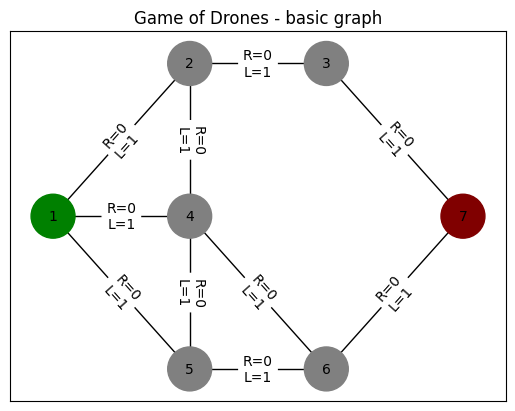

In [14]:
# define parameters
json_file = 'GoD_basic_graph.json'

# load a Graph from a JSON file, 
with open(json_file, 'r') as f:
    data = json.load(f)

G = nx.node_link_graph(data)


# Access the attributes of nodes and edges:
print("Node attributes:")
for node, attrs in G.nodes(data=True):
    print(f"{node}: {attrs}")

print("\nEdge attributes:")
for u, v, attrs in G.edges(data=True):
    print(f"{u}->{v}: {attrs}")


# Draw the graph
def show_graph(graph):
    node_labels = nx.get_node_attributes(graph, 'label')
    node_colors = [attrs['color'] for node, attrs in graph.nodes(data=True)]

    # Show risk and length on each edge
    edge_labels = {(u, v): f"R={attrs['R']}\nL={attrs['L']}" 
                   for u, v, attrs in graph.edges(data=True)}

    # Get positions and colors from JSON 'data'
    networkx_pos = {node_id: tuple(coords) for node_id, coords in data['positions'].items()}
#    node_colors = [node["color"] for node in data["nodes"]]

    nx.draw_networkx(graph, pos=networkx_pos, with_labels=True, labels=node_labels, 
                     node_color=node_colors, node_size=1000, font_size=10)

    nx.draw_networkx_edge_labels(graph, pos=networkx_pos, edge_labels=edge_labels)

    plt.title("Game of Drones - basic graph")
    plt.show()


show_graph(G)

## Section V-A: List of viable paths

The list of viable paths comprises all paths from start node to finish node with a length < maximum range of the drone (B). The NETWORKX package allows finding all simple paths (so no recurring nodes) with a length of <= cutoff. Therefore we use (B+1) as the cutoff value.

The following code generates 'all simple paths' from graph G, so a list of all paths where each node is at maximum only traversed once. From this list of total_paths we extract all paths shorter or equal to 'B', the max range of the drone in terms of edges, the so-called list of 'viable paths'.

Finally, we export the list of 'total_paths' in LaTeX format to the file 'TabII_Simple_Paths.txt' for inclusion as Table II 'Simple Paths' in section V-A

In [8]:
total_paths = list(nx.all_simple_paths(G, "1", "7"))
B = 5

# generate a text file for Table II Simple Paths in section IV-A
def generate_latex_table_from_all_paths(total_paths, G, outfile="TabII_Simple_Paths.txt"):
    success = False
    with open(outfile, "w") as f:
        f.write("\\begin{table} [ht!] \n")
        f.write("\\renewcommand{\\arraystretch}{1.2} \n")
        f.write("\\caption{Simple paths from S to T for graph in Fig.~\\ref{fig:ExampleGraph}} \n")
        f.write("\\label{tab:SimplePathsExample} \n")
        f.write("\t\\centering \n")
        f.write("\t\\begin{tabular}{c c c} \\toprule \n")
        f.write("\t\\textbf{Path ID} & \\textbf{Route} & \\textbf{Length} \\\\ \\midrule \n")

        for idx, path in enumerate(total_paths, 1):
            # Format path string as "1–2–3–7"
            route = "–".join(path)

            # Compute path length based on edge weights
            path_length = sum(G.edges[u, v]['L'] for u, v in zip(path[:-1], path[1:]))

            # Write table row
            f.write(f"\t\t{idx} & {route} & {path_length} \\\\ \n")

            # Insert midrule after every 4 paths
            if idx % 4 == 0:
                f.write("\t\t\\midrule \n")

        f.write("\t\t\\bottomrule \n")
        f.write("\t\\end{tabular} \n")
        f.write("\\end{table}")
        success = True
    return (success, outfile)
        
success, tabIIfile = generate_latex_table_from_all_paths(total_paths, G)
if success:
    print(f"\nData for Table II succesfully captured in file {tabIIfile}")



# now generate the list of viable paths, so paths with number of edges <= B:
print("\n*** Viable Paths in G ***")
viable_paths = [p for p in total_paths if sum(G.edges[u, v]['L'] for u, v in zip(p[:-1], p[1:])) < B+1]
count = 1
for p in viable_paths:
    print(f"[{count}] - length = {len(p)} - path is {p}")
    count+=1
    


Data for Table II succesfully captured in file TabII_Simple_Paths.txt

*** Viable Paths in G ***
[1] - length = 4 - path is ['1', '2', '3', '7']
[2] - length = 6 - path is ['1', '2', '4', '5', '6', '7']
[3] - length = 5 - path is ['1', '2', '4', '6', '7']
[4] - length = 5 - path is ['1', '4', '2', '3', '7']
[5] - length = 5 - path is ['1', '4', '5', '6', '7']
[6] - length = 4 - path is ['1', '4', '6', '7']
[7] - length = 6 - path is ['1', '5', '4', '2', '3', '7']
[8] - length = 5 - path is ['1', '5', '4', '6', '7']
[9] - length = 4 - path is ['1', '5', '6', '7']


## Payoff Matrix

For the payoff matrix we follow the following steps:

    1 Jammer Graph - take clean non-jammer matrix G (all edges are 0) and modify for specific jammer node (adjust edges to risk=0.5)
    2 Path performance - evaluate each path from viable_paths to find mission risk and path length
    3 LexOrd value - for each path and jammer node, find lexord scalar value for payoff table
    4 Payoff table - create table and export to text file

### Creating the jammer graph

In [9]:
# Copy graph G and use jammer node to update edges of new jammerG
def apply_jammer_to_graph(graph, jammer_node, risk_value=0.5):
    jammerG = graph.copy()
    for u, v in graph.edges():
        if jammer_node in (u, v):
            jammerG.edges[u, v]['R'] = risk_value
        else:
            jammerG.edges[u, v]['R'] = 0.0

    jammerG.nodes[jammer_node]['color'] = 'red'
    
    return jammerG



### Path utility

In [33]:
def compute_path_utility(path, jammedG):
    success = 1
    length = 0

    for u, v in zip(path[:-1], path[1:]):
        length += jammedG.edges[u, v]['L']
        success *= (1 - jammedG.edges[u, v]['R'])

    # Lexicographic utility: min risk, then min length
    return (1-success, length)

In [71]:
jammer_nodes = ["2", "3", "4"]  #extend later to include all jammer nodes
edge_risk = 0.5   # needs to move to declaration of constants


def generate_value_matrices(viable_paths, jammer_nodes, G_base,
                            gamma=1000, B=5):
    utility_matrix = []
    payoff_matrix = []

    for path in viable_paths:
        urow = []
        prow = []
        for jammer_node in jammer_nodes:

            print(f"Path = {path}, jammer node is {jammer_node}")
            # Clone the base graph and apply jammer to get a modified graph
            G_mod = apply_jammer_to_graph(G_base, jammer_node)

            succes = 1
            length = 0

            # Compute utility (R_p, L_p) of this path in the modified graph
            for u, v in zip(path[:-1], path[1:]):
                succes *= (1 - G_mod.edges[u, v]['R'])
                length += G_mod.edges[u, v]['L']

                print(f"R={1-success}, L={length}")
                
            risk = 1-success
            
            urow.append((risk, length))
            prow.append( (-1*gamma*risk - length ) / (gamma + B) )
        utility_matrix.append(urow)
        payoff_matrix.append(prow)

    return utility_matrix, payoff_matrix


utility_matrix, payoff_matrix = generate_value_matrices(viable_paths, jammer_nodes, G, 1000, 5)

print(utility_matrix)
print(payoff_matrix)

Path = ['1', '2', '3', '7'], jammer node is 2
R=0, L=1
R=0, L=2
R=0, L=3
Path = ['1', '2', '3', '7'], jammer node is 3
R=0, L=1
R=0, L=2
R=0, L=3
Path = ['1', '2', '3', '7'], jammer node is 4
R=0, L=1
R=0, L=2
R=0, L=3
Path = ['1', '2', '4', '5', '6', '7'], jammer node is 2
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
R=0, L=5
Path = ['1', '2', '4', '5', '6', '7'], jammer node is 3
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
R=0, L=5
Path = ['1', '2', '4', '5', '6', '7'], jammer node is 4
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
R=0, L=5
Path = ['1', '2', '4', '6', '7'], jammer node is 2
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
Path = ['1', '2', '4', '6', '7'], jammer node is 3
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
Path = ['1', '2', '4', '6', '7'], jammer node is 4
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
Path = ['1', '4', '2', '3', '7'], jammer node is 2
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
Path = ['1', '4', '2', '3', '7'], jammer node is 3
R=0, L=1
R=0, L=2
R=0, L=3
R=0, L=4
Path = ['1', '4', '2', '3', '7'], jammer no